## COMP 309 - Assignment 3 Part 3

## (Data Preprocessng MARK II - Test Set)

**The following structure will be followed for this preprocessing stage:**


**Step 1.** *Keep training set and test set seperate so as to avoid data-leakage.*


**Step 2**. *Special step: Encode invalid entries as missing values*.


**Step 3** *Detect and encode potential outliers in numerical features.*


**Step 4.** *Handle missing values and encode categorical features*.
- Cyclical encoding for **key** feature.


**Step 5.** *Feature-Selection.* - Done before encoding **textual** data as removal of columns may destroy the meaning behind the encoding.


**Step 6.** Encoding **textual** features:
- Bag-of-Words for **textual** features.
- **Predict** using a ml model what the NaNs should be (Supervised ML-imputation).


**Step 7.** *Apply Scaling (numerical features).*
- Includes normalising distributions of explanatory variables.


**Step 8.** *Save and load data transforms to be used in model-fitting in part 3 of assignment.*

### Step 1 - Split training and testing sets:

**Import dependencies:**

In [1]:
 import pandas as pd

**Acquire test set (kept seperate from test set to prevent data-leakage):**

In [2]:
test_set = pd.read_csv('test.csv')
test_set

instance_id             artist_name         track_name  \
0                1                 Tsuruda           Brrrap!!   
1                2         Aretha Franklin      Soul Serenade   
2                3                  Asiahn          Curiosity   
3                4       Dora The Explorer  Ni Hao My Friends   
4                5            Matthew West  Hello, My Name Is   
...            ...                     ...                ...   
30926        30927  Kimbo Children's Music     The Royal Ball   
30927        30928                Interpol         Obstacle 1   
30928        30929             Iron & Wine        Lion's Mane   
30929        30930                Wardruna           Helvegen   
30930        30931        Three Days Grace     Me Against You   

                     track_id  popularity  acousticness  danceability  \
0      2ESzaP7ZoabnJA3TTG71Ul          41      0.255000         0.699   
1      18sDWMHFfgDOh1zMrFJt1C          38      0.364000         0.649   
2      7itEG38P49CQ3miMcoYzJe          55      0.445000         0.457   
3      4yK3xXuNrkSq0OVjKUaCkY           7      0.332000         0.756   
4      7GxBuIJugWanLsYj0mDrFX          54      0.000583         0.595   
...                       ...         ...           ...           ...   
30926  33pgY0vezKpyTEU5MYQDZk           0      0.367000         0.609   
30927  0xjdytIAHKrjsdHoLDkq4p          59      0.000052         0.377   
30928  69pwmeyvQMuHMtkCmpEWhQ          43      0.884000         0.603   
30929  4qZh3yJ7tILlDD0Wmv7Ftj          57      0.657000         0.234   
30930  3Be38YoxiGBLHQ8lQRJoqw          53      0.000269         0.614   

       duration_ms  energy  instrumentalness key  liveness  loudness   mode  \
0           218733   0.949          0.256000  F#    0.0983    -4.110  Minor   
1           159067   0.296          0.000008  G#    0.1320    -9.389  Major   
2           234802   0.425          0.000000   E    0.0714   -10.500  Minor   
3            78760   0.543          0.000000  G#    0.3330    -5.477  Major   
4           223427   0.894          0.000001   B    0.3260    -4.115  Major   
...            ...     ...               ...  ..       ...       ...    ...   
30926       205840   0.498          0.000000   G    0.0756    -7.197  Major   
30927       251333   0.937          0.578000   F    0.0676    -4.898  Major   
30928           -1   0.346          0.916000   G    0.1040   -11.481  Major   
30929       431867   0.510          0.293000   F    0.5450   -13.398  Minor   
30930       209027   0.826          0.000002   G    0.0989    -7.395  Minor   

       speechiness    tempo time_signature  valence  
0           0.3890  146.064          4-Apr    0.365  
1           0.0334   81.911          4-Apr    0.600  
2           0.2430  201.472          4-Apr    0.498  
3           0.0279    88.98          4-Apr    0.839  
4           0.0323  101.987          4-Apr    0.643  
...            ...      ...            ...      ...  
30926       0.0546  189.823          3-Apr    0.664  
30927       0.0649  120.532          4-Apr    0.375  
30928       0.0303    88.45          4-Apr    0.619  
30929       0.0498        ?          4-Apr    0.191  
30930       0.0514  111.997          4-Apr    0.431  

[30931 rows x 18 columns]

**Classify features according to data type:**

In [3]:
# deal with 'tempo':
test_set['tempo'] = test_set['tempo'].replace(['?'], '-1')
test_set[["tempo"]] = test_set[["tempo"]].apply(pd.to_numeric)

# classify features according to type:
numerical_features=['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
hashing_features=['instance_id', 'track_id']
nominal_features=['mode', 'genre']
ordinal_features=['time_signature']
textual_features=['artist_name', 'track_name'] # word-embedding
cyclical_features=['key']

**Restore feature types:**

In [4]:
def restore_types(data, numerical_features):
    for feature in data.columns:
        if feature in numerical_features:
            data[[feature]]=data[[feature]].apply(pd.to_numeric)
    return data

### Step 2 - Encode invalid entries as missing values:

Strategy: Based on the findings reported in the preliminary EDA, the following measures will be taken when handling missing values in the dataset.


**Numerical features**:


1. *duration_ms:* values of -1 will be replaced with NaNs.


**Categorical features**:


1. *artist_name:* values of 'empty_field' will be replaced with NaNs.
2. *tempo:* values of '?' (now having been changed to -1) will be replaced with NaNs.

In [5]:
# import dependencies
import numpy as np

In [6]:
# compute percentage of missing values per feature in the data set:
def display_nan_proportions(data):
    percent_missing = data.isnull().sum() * 100 / len(data)
    missing_values = pd.DataFrame({'percent_missing':percent_missing.round(2)})

    missing_values.drop(missing_values.index[missing_values['percent_missing'] == 0], inplace=True)
    return missing_values

In [7]:
# feature (duration_ms): replace all -1 entries with NaN values: 
test_set['duration_ms'] = test_set['duration_ms'].replace([-1], np.nan)

# feature (artist_name): replace all 'empty_field' entries with NaN values:
test_set['artist_name'] = test_set['artist_name'].replace(['empty_field'], np.nan)

# feature (tempo): replace all '?' entries with NaN values:
test_set['tempo'] = test_set['tempo'].replace([-1], np.nan)

In [8]:
display_nan_proportions(test_set)

percent_missing
artist_name            19.99
duration_ms            20.16
tempo                  14.87

### Step 3 - Outliers, median imputation (for numerical features):

**Interquartile Range Method**:

**Handle outliers** (IQR):

In [9]:
# import dependencies:
import numpy as np

In [10]:
def outlier_range(feature):
    Q1, Q3 = np.nanpercentile(feature, [25, 75])
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def outlier_nan_imputation(data):
    features = data.columns
    for feature in features:
        if feature in numerical_features:
            lower_bound, upper_bound = outlier_range(data[feature])
            data[feature] = np.where((data[feature] < lower_bound) | (data[feature] > upper_bound), np.nan, data[feature])
    return data

In [11]:
test_set = outlier_nan_imputation(test_set)

In [12]:
display_nan_proportions(test_set)

percent_missing
artist_name                 19.99
popularity                   0.02
danceability                 0.24
duration_ms                 24.16
instrumentalness            21.27
liveness                    11.62
loudness                     2.78
speechiness                 14.04
tempo                       14.92

**Impute the median value for all features in the list above (except 'artist_name'):**

In [13]:
# store feature labels:
def edit_feature_names(features):
    for i in range(len(features)):
        if 'variancethreshold__' in features[i]:
            features[i]=features[i][19:len(features[i])] 
        if 'remainder__' in features[i]:
            features[i]=features[i][11:len(features[i])] 
        if 'simpleimputer__' in features[i]:
            features[i]=features[i][15:len(features[i])] 
        if 'onehotencoder__' in features[i]:
            features[i]=features[i][15:len(features[i])] 
        if 'ordinalencoder__' in features[i]:
            features[i]=features[i][16:len(features[i])] 
        if 'minmaxscaler__' in features[i]:
            features[i]=features[i][14:len(features[i])] 
        if 'powertransformer__' in features[i]:
            features[i]=features[i][18:len(features[i])]
    return features

In [14]:
def impute_median(data):
    # import dependencies:
    from sklearn.impute import SimpleImputer
    from sklearn.compose import make_column_transformer
    
    # make column transformer:
    imp=SimpleImputer(missing_values=np.nan, strategy='median')
    impute_list=['popularity', 'danceability', 'duration_ms', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo']
    median_ct = make_column_transformer(
        (imp, impute_list),
        remainder='passthrough'
    )
    
    # implement column transformer:
    data = pd.DataFrame(median_ct.fit_transform(data))

    # restore labels:
    data.columns = edit_feature_names(median_ct.get_feature_names_out())

    # restore feature types:
    numerical_features=['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
    restore_types(data, numerical_features)
    
    return data

In [15]:
test_set=impute_median(test_set)

In [16]:
display_nan_proportions(test_set)

percent_missing
artist_name            19.99

### Step 4 - Encoding Features:

In [17]:
# classify features according to type:
numerical_features=['popularity', 'acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence']
hashing_features=['instance_id', 'track_id']
nominal_features=['mode']
ordinal_features=['time_signature']
cyclical_features=['key']
#textual_features=['artist_name', 'track_name']

**Encoding: Hashing**:

In [18]:
# import dependencies:
from sklearn.feature_extraction import FeatureHasher

# hash:
def hashing(data):
    hashed_features_list = []
    features = data.columns
    for feature in features:
        if feature in hashing_features:
            data[feature]=data[feature].astype(str)
            fh = FeatureHasher(n_features=3, input_type='string')
            hashed_features = fh.fit_transform(data[feature])
            hashed_features = hashed_features.toarray()
            hashed_features = pd.DataFrame(hashed_features)
            hashed_features.columns = ['Hashed ' + feature + ' 1', 'Hashed ' + feature + ' 2', 'Hashed ' + feature + ' 3']
            hashed_features_list.append(hashed_features)
    return hashed_features_list

**EDIT:** Hash vs Drop

In [19]:
# acquire hashed features:
#hashed_features = hashing(test_set)

# drop features to be hashed encoded:
#test_set = test_set.drop('instance_id', axis=1)
#test_set = test_set.drop('track_id', axis=1)

# merge hashed features to data:
#for i in range(len(hashed_features)):
#    test_set = pd.concat([test_set.reset_index(drop=True), hashed_features[i].reset_index(drop=True)], axis=1)

In [20]:
test_set=test_set.drop('instance_id', axis=1)
test_set=test_set.drop('track_id', axis=1)

**Encoding: Nominal**

In [21]:
# import dependencies
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# create the OneHotEncoder and SimpleImputer:
ohe = OneHotEncoder(sparse=False)

# create column transformer:
nominal_ct = make_column_transformer(
    (ohe, nominal_features),
    remainder='passthrough'
)

# transform the data:
test_set = pd.DataFrame(nominal_ct.fit_transform(test_set))

# restore labels:
test_set.columns = edit_feature_names(nominal_ct.get_feature_names_out())

# restore feature types:
restore_types(test_set, numerical_features)

mode_Major mode_Minor  popularity  danceability  duration_ms  \
0            0.0        1.0        41.0         0.699     218733.0   
1            1.0        0.0        38.0         0.649     159067.0   
2            0.0        1.0        55.0         0.457     234802.0   
3            1.0        0.0         7.0         0.756      78760.0   
4            1.0        0.0        54.0         0.595     223427.0   
...          ...        ...         ...           ...          ...   
30926        1.0        0.0         0.0         0.609     205840.0   
30927        1.0        0.0        59.0         0.377     251333.0   
30928        1.0        0.0        43.0         0.603     213093.0   
30929        0.0        1.0        57.0         0.234     213093.0   
30930        0.0        1.0        53.0         0.614     209027.0   

       instrumentalness  liveness  loudness  speechiness    tempo  \
0              0.000003    0.0983    -4.110       0.0498  146.064   
1              0.000008    0.1320    -9.389       0.0334   81.911   
2              0.000000    0.0714   -10.500       0.2430  201.472   
3              0.000000    0.3330    -5.477       0.0279   88.980   
4              0.000001    0.3260    -4.115       0.0323  101.987   
...                 ...       ...       ...          ...      ...   
30926          0.000000    0.0756    -7.197       0.0546  189.823   
30927          0.000003    0.0676    -4.898       0.0649  120.532   
30928          0.000003    0.1040   -11.481       0.0303   88.450   
30929          0.000003    0.5450   -13.398       0.0498  116.948   
30930          0.000002    0.0989    -7.395       0.0514  111.997   

                  artist_name         track_name  acousticness  energy key  \
0                     Tsuruda           Brrrap!!      0.255000   0.949  F#   
1             Aretha Franklin      Soul Serenade      0.364000   0.296  G#   
2                      Asiahn          Curiosity      0.445000   0.425   E   
3           Dora The Explorer  Ni Hao My Friends      0.332000   0.543  G#   
4                Matthew West  Hello, My Name Is      0.000583   0.894   B   
...                       ...                ...           ...     ...  ..   
30926  Kimbo Children's Music     The Royal Ball      0.367000   0.498   G   
30927                Interpol         Obstacle 1      0.000052   0.937   F   
30928             Iron & Wine        Lion's Mane      0.884000   0.346   G   
30929                Wardruna           Helvegen      0.657000   0.510   F   
30930        Three Days Grace     Me Against You      0.000269   0.826   G   

      time_signature  valence  
0              4-Apr    0.365  
1              4-Apr    0.600  
2              4-Apr    0.498  
3              4-Apr    0.839  
4              4-Apr    0.643  
...              ...      ...  
30926          3-Apr    0.664  
30927          4-Apr    0.375  
30928          4-Apr    0.619  
30929          4-Apr    0.191  
30930          4-Apr    0.431  

[30931 rows x 17 columns]

**Encoding: Ordinal** 

**EDIT:** disabled median imputation and replaced as a valid entry:

In [22]:
# handle '0/4' entry:
#mode=test_set['time_signature'].mode()
#test_set = test_set.replace(['0/4'], mode)

In [23]:
# import dependencies:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import make_column_transformer

# set up ordinal encoder parameters:
time_signature_order=['0/4', '1-Apr', '3-Apr', '4-Apr', '5-Apr']

# set up ordinal encoders:
oe=OrdinalEncoder(categories=[time_signature_order])

# create column transformer:
ordinal_ct = make_column_transformer(
    (oe, ordinal_features),
    remainder='passthrough'
)

# perform transforms:
test_set=pd.DataFrame(ordinal_ct.fit_transform(test_set))

# restore labels:
test_set.columns = edit_feature_names(ordinal_ct.get_feature_names_out())

# restore feature types:
restore_types(test_set, numerical_features)

time_signature mode_Major mode_Minor  popularity  danceability  \
0                3.0        0.0        1.0        41.0         0.699   
1                3.0        1.0        0.0        38.0         0.649   
2                3.0        0.0        1.0        55.0         0.457   
3                3.0        1.0        0.0         7.0         0.756   
4                3.0        1.0        0.0        54.0         0.595   
...              ...        ...        ...         ...           ...   
30926            2.0        1.0        0.0         0.0         0.609   
30927            3.0        1.0        0.0        59.0         0.377   
30928            3.0        1.0        0.0        43.0         0.603   
30929            3.0        0.0        1.0        57.0         0.234   
30930            3.0        0.0        1.0        53.0         0.614   

       duration_ms  instrumentalness  liveness  loudness  speechiness  \
0         218733.0          0.000003    0.0983    -4.110       0.0498   
1         159067.0          0.000008    0.1320    -9.389       0.0334   
2         234802.0          0.000000    0.0714   -10.500       0.2430   
3          78760.0          0.000000    0.3330    -5.477       0.0279   
4         223427.0          0.000001    0.3260    -4.115       0.0323   
...            ...               ...       ...       ...          ...   
30926     205840.0          0.000000    0.0756    -7.197       0.0546   
30927     251333.0          0.000003    0.0676    -4.898       0.0649   
30928     213093.0          0.000003    0.1040   -11.481       0.0303   
30929     213093.0          0.000003    0.5450   -13.398       0.0498   
30930     209027.0          0.000002    0.0989    -7.395       0.0514   

         tempo             artist_name         track_name  acousticness  \
0      146.064                 Tsuruda           Brrrap!!      0.255000   
1       81.911         Aretha Franklin      Soul Serenade      0.364000   
2      201.472                  Asiahn          Curiosity      0.445000   
3       88.980       Dora The Explorer  Ni Hao My Friends      0.332000   
4      101.987            Matthew West  Hello, My Name Is      0.000583   
...        ...                     ...                ...           ...   
30926  189.823  Kimbo Children's Music     The Royal Ball      0.367000   
30927  120.532                Interpol         Obstacle 1      0.000052   
30928   88.450             Iron & Wine        Lion's Mane      0.884000   
30929  116.948                Wardruna           Helvegen      0.657000   
30930  111.997        Three Days Grace     Me Against You      0.000269   

       energy key  valence  
0       0.949  F#    0.365  
1       0.296  G#    0.600  
2       0.425   E    0.498  
3       0.543  G#    0.839  
4       0.894   B    0.643  
...       ...  ..      ...  
30926   0.498   G    0.664  
30927   0.937   F    0.375  
30928   0.346   G    0.619  
30929   0.510   F    0.191  
30930   0.826   G    0.431  

[30931 rows x 17 columns]

**Encoding: Cyclical**

In [24]:
# import dependencies:
import math
from math import pi

In [25]:
# helper methods needed to encode cyclical nature 
# of 'key' feature:
def sin_transformation(x):
    return math.sin(2 * pi * x / np.max(entries))

def cos_transformation(x):
    return math.cos(2 * pi * x / np.max(entries))

In [26]:
# initial setup:
entries=np.array(test_set['key'].index + 1)
test_set['key'].index=entries

# perform computations:
test_set['key_sin']=test_set['key'].index.to_series().apply(sin_transformation)
test_set['key_cos']=test_set['key'].index.to_series().apply(cos_transformation)

# drop the pre-transformed feature 'key':
test_set = test_set.drop('key', axis=1)

In [27]:
# import dependencies:
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
    
# make column transformer:
imp=SimpleImputer(missing_values=np.nan, strategy='median')
impute_list=['key_sin', 'key_cos']
median_ct = make_column_transformer(
    (imp, impute_list),
    remainder='passthrough'
)
    
# implement column transformer:
test_set=pd.DataFrame(median_ct.fit_transform(test_set))

# restore labels:
test_set.columns = edit_feature_names(median_ct.get_feature_names_out())

# restore feature types:
restore_types(test_set, numerical_features)

key_sin   key_cos time_signature mode_Major mode_Minor  popularity  \
0           0.0 -0.000051            3.0        0.0        1.0        41.0   
1      0.000203       1.0            3.0        1.0        0.0        38.0   
2      0.000406       1.0            3.0        0.0        1.0        55.0   
3      0.000609       1.0            3.0        1.0        0.0         7.0   
4      0.000813       1.0            3.0        1.0        0.0        54.0   
...         ...       ...            ...        ...        ...         ...   
30926 -0.001016  0.999999            2.0        1.0        0.0         0.0   
30927 -0.000813       1.0            3.0        1.0        0.0        59.0   
30928 -0.000609       1.0            3.0        1.0        0.0        43.0   
30929 -0.000406       1.0            3.0        0.0        1.0        57.0   
30930 -0.000203       1.0            3.0        0.0        1.0        53.0   

       danceability  duration_ms  instrumentalness  liveness  loudness  \
0             0.699     218733.0          0.000003    0.0983    -4.110   
1             0.649     159067.0          0.000008    0.1320    -9.389   
2             0.457     234802.0          0.000000    0.0714   -10.500   
3             0.756      78760.0          0.000000    0.3330    -5.477   
4             0.595     223427.0          0.000001    0.3260    -4.115   
...             ...          ...               ...       ...       ...   
30926         0.609     205840.0          0.000000    0.0756    -7.197   
30927         0.377     251333.0          0.000003    0.0676    -4.898   
30928         0.603     213093.0          0.000003    0.1040   -11.481   
30929         0.234     213093.0          0.000003    0.5450   -13.398   
30930         0.614     209027.0          0.000002    0.0989    -7.395   

       speechiness    tempo             artist_name         track_name  \
0           0.0498  146.064                 Tsuruda           Brrrap!!   
1           0.0334   81.911         Aretha Franklin      Soul Serenade   
2           0.2430  201.472                  Asiahn          Curiosity   
3           0.0279   88.980       Dora The Explorer  Ni Hao My Friends   
4           0.0323  101.987            Matthew West  Hello, My Name Is   
...            ...      ...                     ...                ...   
30926       0.0546  189.823  Kimbo Children's Music     The Royal Ball   
30927       0.0649  120.532                Interpol         Obstacle 1   
30928       0.0303   88.450             Iron & Wine        Lion's Mane   
30929       0.0498  116.948                Wardruna           Helvegen   
30930       0.0514  111.997        Three Days Grace     Me Against You   

       acousticness  energy  valence  
0          0.255000   0.949    0.365  
1          0.364000   0.296    0.600  
2          0.445000   0.425    0.498  
3          0.332000   0.543    0.839  
4          0.000583   0.894    0.643  
...             ...     ...      ...  
30926      0.367000   0.498    0.664  
30927      0.000052   0.937    0.375  
30928      0.884000   0.346    0.619  
30929      0.657000   0.510    0.191  
30930      0.000269   0.826    0.431  

[30931 rows x 18 columns]

In [28]:
display_nan_proportions(test_set)

percent_missing
artist_name            19.99

### Step 5: Feature Selection

In [29]:
# import dependencies:
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import make_column_transformer
import matplotlib.pyplot as plt

In [30]:
# obtain the numerical feature labels:
frame=["artist_name", "track_name"]
features=test_set.columns
features=features.drop(frame)

# apply transform with each threshold
feature_names = []
features_removed = []
thresholds = np.arange(0.0, 0.05, 0.01)
results = list()
pos = 0

for t in thresholds:
    # create variance threshold:
    var_thres=VarianceThreshold(threshold=t) 
    
    # create a column transformer:
    ct=make_column_transformer(
        (var_thres, features),
        remainder='passthrough'
    )
    
    # transform the input data
    X_sel=ct.fit_transform(test_set)
    
    # store the result
    edited_feature_names=edit_feature_names(ct.get_feature_names_out())
    feature_names.append(edited_feature_names)
    
    # determine the number of input features and display:
    n_features = X_sel.shape[1]
    features_removed.append(list(set(numerical_features) - set(edited_feature_names)))
    print('features removed:', features_removed[pos])
    print('>Threshold=%.2f, Features=%d' % (t, n_features), '\n')
    results.append(n_features)
    pos = pos + 1

features removed: []
>Threshold=0.00, Features=18 

features removed: ['speechiness', 'instrumentalness']
>Threshold=0.01, Features=16 

features removed: ['speechiness', 'liveness', 'instrumentalness']
>Threshold=0.02, Features=15 

features removed: ['speechiness', 'liveness', 'danceability', 'instrumentalness']
>Threshold=0.03, Features=14 

features removed: ['speechiness', 'liveness', 'danceability', 'instrumentalness']
>Threshold=0.04, Features=14 



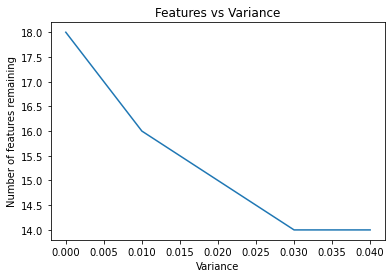

In [31]:
# plot the threshold vs the number of selected features
plt.plot(thresholds, results)
plt.title("Features vs Variance")
plt.xlabel("Variance")
plt.ylabel("Number of features remaining")
plt.show()

In [32]:
def remove_low_variance_features(data, remove_features):
    features=data.columns
    for feature in features:
        if feature in remove_features:
            data = data.drop(feature, axis=1)
    return data

Based on the results above, the following features will be removed:

1. **liveness** 
2. **speechiness**
3. **instrumentalness**
4. **danceability**

**EDIT:** Did NOT remove features:

In [33]:
#features=['liveness', 'speechiness', 'instrumentalness', 'danceability']
#test_set=remove_low_variance_features(test_set, features)

In [34]:
test_set

key_sin   key_cos time_signature mode_Major mode_Minor  popularity  \
0           0.0 -0.000051            3.0        0.0        1.0        41.0   
1      0.000203       1.0            3.0        1.0        0.0        38.0   
2      0.000406       1.0            3.0        0.0        1.0        55.0   
3      0.000609       1.0            3.0        1.0        0.0         7.0   
4      0.000813       1.0            3.0        1.0        0.0        54.0   
...         ...       ...            ...        ...        ...         ...   
30926 -0.001016  0.999999            2.0        1.0        0.0         0.0   
30927 -0.000813       1.0            3.0        1.0        0.0        59.0   
30928 -0.000609       1.0            3.0        1.0        0.0        43.0   
30929 -0.000406       1.0            3.0        0.0        1.0        57.0   
30930 -0.000203       1.0            3.0        0.0        1.0        53.0   

       danceability  duration_ms  instrumentalness  liveness  loudness  \
0             0.699     218733.0          0.000003    0.0983    -4.110   
1             0.649     159067.0          0.000008    0.1320    -9.389   
2             0.457     234802.0          0.000000    0.0714   -10.500   
3             0.756      78760.0          0.000000    0.3330    -5.477   
4             0.595     223427.0          0.000001    0.3260    -4.115   
...             ...          ...               ...       ...       ...   
30926         0.609     205840.0          0.000000    0.0756    -7.197   
30927         0.377     251333.0          0.000003    0.0676    -4.898   
30928         0.603     213093.0          0.000003    0.1040   -11.481   
30929         0.234     213093.0          0.000003    0.5450   -13.398   
30930         0.614     209027.0          0.000002    0.0989    -7.395   

       speechiness    tempo             artist_name         track_name  \
0           0.0498  146.064                 Tsuruda           Brrrap!!   
1           0.0334   81.911         Aretha Franklin      Soul Serenade   
2           0.2430  201.472                  Asiahn          Curiosity   
3           0.0279   88.980       Dora The Explorer  Ni Hao My Friends   
4           0.0323  101.987            Matthew West  Hello, My Name Is   
...            ...      ...                     ...                ...   
30926       0.0546  189.823  Kimbo Children's Music     The Royal Ball   
30927       0.0649  120.532                Interpol         Obstacle 1   
30928       0.0303   88.450             Iron & Wine        Lion's Mane   
30929       0.0498  116.948                Wardruna           Helvegen   
30930       0.0514  111.997        Three Days Grace     Me Against You   

       acousticness  energy  valence  
0          0.255000   0.949    0.365  
1          0.364000   0.296    0.600  
2          0.445000   0.425    0.498  
3          0.332000   0.543    0.839  
4          0.000583   0.894    0.643  
...             ...     ...      ...  
30926      0.367000   0.498    0.664  
30927      0.000052   0.937    0.375  
30928      0.884000   0.346    0.619  
30929      0.657000   0.510    0.191  
30930      0.000269   0.826    0.431  

[30931 rows x 18 columns]

### Step 6: Textual Encoding:

**Encoding: Textual** *(Bag-of-Words)*

In [35]:
# helper method to aid in constructing train-test sets:
def drop_features(data):
    features=["time_signature", "mode_Major", "mode_Minor", "Hashed instance_id 1",
        "Hashed instance_id 2", "Hashed instance_id 3", "Hashed track_id 1", "Hashed track_id 2",          
        "Hashed track_id 3", "genre", "track_name"]
    
    return data.drop(features, axis=1)

#"genre_Alternative", 
#"genre_Blues", "genre_Children's Music", "genre_Comedy", "genre_Electronic", "genre_Folk", 
#"genre_Hip-Hop", "genre_Movie", "genre_Ska", "genre_Soul", 

In [36]:
# drop:
#train_set=train_set.dropna()
test_set=test_set.drop('track_name', axis=1)

In [37]:
test_set

key_sin   key_cos time_signature mode_Major mode_Minor  popularity  \
0           0.0 -0.000051            3.0        0.0        1.0        41.0   
1      0.000203       1.0            3.0        1.0        0.0        38.0   
2      0.000406       1.0            3.0        0.0        1.0        55.0   
3      0.000609       1.0            3.0        1.0        0.0         7.0   
4      0.000813       1.0            3.0        1.0        0.0        54.0   
...         ...       ...            ...        ...        ...         ...   
30926 -0.001016  0.999999            2.0        1.0        0.0         0.0   
30927 -0.000813       1.0            3.0        1.0        0.0        59.0   
30928 -0.000609       1.0            3.0        1.0        0.0        43.0   
30929 -0.000406       1.0            3.0        0.0        1.0        57.0   
30930 -0.000203       1.0            3.0        0.0        1.0        53.0   

       danceability  duration_ms  instrumentalness  liveness  loudness  \
0             0.699     218733.0          0.000003    0.0983    -4.110   
1             0.649     159067.0          0.000008    0.1320    -9.389   
2             0.457     234802.0          0.000000    0.0714   -10.500   
3             0.756      78760.0          0.000000    0.3330    -5.477   
4             0.595     223427.0          0.000001    0.3260    -4.115   
...             ...          ...               ...       ...       ...   
30926         0.609     205840.0          0.000000    0.0756    -7.197   
30927         0.377     251333.0          0.000003    0.0676    -4.898   
30928         0.603     213093.0          0.000003    0.1040   -11.481   
30929         0.234     213093.0          0.000003    0.5450   -13.398   
30930         0.614     209027.0          0.000002    0.0989    -7.395   

       speechiness    tempo             artist_name  acousticness  energy  \
0           0.0498  146.064                 Tsuruda      0.255000   0.949   
1           0.0334   81.911         Aretha Franklin      0.364000   0.296   
2           0.2430  201.472                  Asiahn      0.445000   0.425   
3           0.0279   88.980       Dora The Explorer      0.332000   0.543   
4           0.0323  101.987            Matthew West      0.000583   0.894   
...            ...      ...                     ...           ...     ...   
30926       0.0546  189.823  Kimbo Children's Music      0.367000   0.498   
30927       0.0649  120.532                Interpol      0.000052   0.937   
30928       0.0303   88.450             Iron & Wine      0.884000   0.346   
30929       0.0498  116.948                Wardruna      0.657000   0.510   
30930       0.0514  111.997        Three Days Grace      0.000269   0.826   

       valence  
0        0.365  
1        0.600  
2        0.498  
3        0.839  
4        0.643  
...        ...  
30926    0.664  
30927    0.375  
30928    0.619  
30929    0.191  
30930    0.431  

[30931 rows x 17 columns]

**Attempt to predict missing values with a ML model:**

In [38]:
# create a separate instance of the train_set:
dummy_test=test_set

# acquire test_data:
mini_test = dummy_test[dummy_test['artist_name'].isnull()==True]

# acquire train_data:
mini_train = dummy_test[dummy_test['artist_name'].isnull()==False]

# acquire y_train:
y_train = mini_train['artist_name']

# acquire X_train:
X_train=mini_train.drop("artist_name",axis=1)

In [39]:
# vectorize y_train names:
from sklearn.feature_extraction.text import CountVectorizer #TfidfVectorizer
vect=CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.00, max_df=1.0, max_features=100)# max_features=1500, min_df=5, max_df=0.7
bag_of_words=pd.DataFrame(vect.fit_transform(y_train).toarray())
bag_of_words.columns=vect.get_feature_names_out()
y_train=bag_of_words

In [40]:
# create model:
from sklearn.ensemble import RandomForestClassifier 
rf=RandomForestClassifier()
rf.fit(X_train, y_train)

# acquire X_test:
X_test=mini_test.drop('artist_name', axis=1)

# get predicted NaNs:
pred=rf.predict(X_test)
missing_values_indices=X_test.index

**The two components needed to replace the 'artist_name' feature:**

In [41]:
# get predicted NaNs:
missing_values=pred
missing_values_indices=X_test.index

# get encoded non_NaNs:
filled_positions=test_set['artist_name'].dropna()
filled_positions_indices=filled_positions.index

In [42]:
# vectorize filled_positions names:
from sklearn.feature_extraction.text import CountVectorizer #TfidfVectorizer
vect=CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.00, max_df=1.0, max_features=100)# max_features=1500, min_df=5, max_df=0.7
bag_of_words=pd.DataFrame(vect.fit_transform(filled_positions).toarray())
bag_of_words.columns=vect.get_feature_names_out()
filled_positions=bag_of_words

In [43]:
# update missing values column labels:
missing_values = pd.DataFrame(missing_values)
missing_values.columns=filled_positions.columns
missing_values

alan  alan menken  andrew  bad  bailey  band  benson  big  big fish  \
0        0            0       0    0       0     0       0    0         0   
1        0            0       0    0       0     0       0    0         0   
2        0            0       0    0       0     0       0    0         0   
3        0            0       0    0       0     0       0    0         0   
4        0            0       0    0       0     0       0    0         0   
...    ...          ...     ...  ...     ...   ...     ...  ...       ...   
6177     0            0       0    0       0     0       0    0         0   
6178     0            0       0    0       0     0       0    0         0   
6179     0            0       0    0       0     0       0    0         0   
6180     0            0       0    0       0     0       0    0         0   
6181     0            0       0    0       0     0       0    0         0   

      black  ...  smith  songs  songs company  steve  stone  taylor  tom  \
0         0  ...      0      0              0      0      0       0    0   
1         0  ...      0      0              0      0      0       0    0   
2         0  ...      0      0              0      0      0       0    0   
3         0  ...      0      0              0      0      0       0    0   
4         0  ...      0      0              0      0      0       0    0   
...     ...  ...    ...    ...            ...    ...    ...     ...  ...   
6177      0  ...      0      0              0      0      0       0    0   
6178      0  ...      0      0              0      0      0       0    0   
6179      0  ...      0      0              0      0      0       0    0   
6180      0  ...      0      0              0      0      0       0    0   
6181      0  ...      0      0              0      0      0       0    0   

      white  williams  young  
0         0         0      0  
1         0         0      0  
2         0         0      0  
3         0         0      0  
4         0         0      0  
...     ...       ...    ...  
6177      0         0      0  
6178      0         0      0  
6179      0         0      0  
6180      0         0      0  
6181      0         0      0  

[6182 rows x 100 columns]

**Combine the two components together:**

In [44]:
# import dependencies for progress bar:
from tqdm import tqdm_notebook as tqdm 

# surpress warnings:
import warnings
warnings.filterwarnings('ignore') # setting ignore as a parameter

# Creating an empty Dataframe with column names only
dfObj = pd.DataFrame(columns=missing_values.columns)

# initialise counters:
j=0
k=0

# populate entries:
for i in tqdm(range(len(test_set['artist_name']))):
    if i in missing_values_indices:
        dfObj = pd.DataFrame(np.insert(dfObj.values, i, missing_values.iloc[j], axis=0)) #, ignore_index=True)
        j=j+1
    if i in filled_positions_indices:
        dfObj = pd.DataFrame(np.insert(dfObj.values, i, filled_positions.iloc[k], axis=0)) #, ignore_index=True)
        k=k+1

  0%|          | 0/30931 [00:00<?, ?it/s]

In [45]:
dfObj.columns=missing_values.columns 
dfObj.shape

(30931, 100)

In [46]:
test_set.shape

(30931, 17)

**Replace 'artist_name' feature with new merged encoded representation:**

In [47]:
# concatenate:
test_set.reset_index(drop=True, inplace=True)
dfObj.reset_index(drop=True, inplace=True)
frames=[test_set, dfObj]
test_set=pd.concat(frames, axis=1)
test_set=test_set.drop('artist_name', axis=1)

In [48]:
test_set.shape

(30931, 116)

### Step 7: Scaling

**Display distributions of relevant features before transforms:** 

**EDIT:** Changed features:

array([[<AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

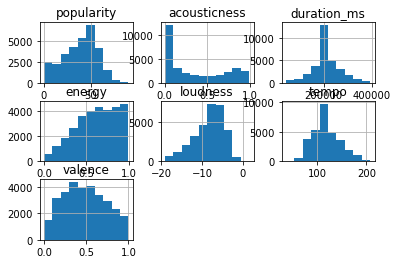

In [49]:
# acquire relevant features:
features=['time_signature', 'mode_Major', 'mode_Minor', 'popularity', 'acousticness', 'duration_ms', 'energy',
          'loudness', 'tempo', 'valence', 'key_sin', 'key_cos']

# display histograms:
test_set[features].hist()

In [50]:
# acquire relevant features:
#features=['time_signature', 'mode_Major', 'mode_Minor', 'popularity', 'acousticness', 'duration_ms', 'energy',
#          'loudness', 'tempo', 'valence', 'Hashed instance_id 1', 'Hashed instance_id 2', 'Hashed instance_id 3', 
#          'Hashed track_id 1', 'Hashed track_id 2', 'Hashed track_id 3', 'key_sin', 'key_cos']
#
# display histograms:
#test_set[features].hist()

**Apply MinMaxScaler** (Box-Cox transform does not work on negative values):

In [51]:
# import dependencies:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_transformer

# create the scaler:
scaler = MinMaxScaler(feature_range=(1, 2))

# create column transformer:
scaler_ct = make_column_transformer(
    (scaler, features),
    remainder='passthrough'
)

# transform the data:
test_set = pd.DataFrame(scaler_ct.fit_transform(test_set)) 

# restore labels:
test_set.columns = edit_feature_names(scaler_ct.get_feature_names_out())

# restore feature types:
restore_types(test_set, numerical_features)

time_signature mode_Major mode_Minor  popularity  acousticness  \
0               1.75        1.0        2.0    1.455556      1.256023   
1               1.75        2.0        1.0    1.422222      1.365461   
2               1.75        1.0        2.0    1.611111      1.446786   
3               1.75        2.0        1.0    1.077778      1.333332   
4               1.75        2.0        1.0    1.600000      1.000584   
...              ...        ...        ...         ...           ...   
30926            1.5        2.0        1.0    1.000000      1.368473   
30927           1.75        2.0        1.0    1.655556      1.000051   
30928           1.75        2.0        1.0    1.477778      1.887550   
30929           1.75        1.0        2.0    1.633333      1.659638   
30930           1.75        1.0        2.0    1.588889      1.000269   

       duration_ms    energy  loudness     tempo  valence  ... smith songs  \
0         1.502580  1.949938  1.725264  1.641938    1.365  ...     0     0   
1         1.332740  1.296125  1.470597  1.271100    1.600  ...     0     0   
2         1.548321  1.425286  1.417000  1.962224    1.498  ...     0     0   
3         1.104145  1.543432  1.659318  1.311963    1.839  ...     0     0   
4         1.515942  1.894869  1.725023  1.387150    1.643  ...     0     0   
...            ...       ...       ...       ...      ...  ...   ...   ...   
30926     1.465880  1.498376  1.576342  1.894887    1.664  ...     0     0   
30927     1.595377  1.937923  1.687250  1.494350    1.375  ...     0     0   
30928     1.486526  1.346187  1.369675  1.308899    1.619  ...     0     0   
30929     1.486526  1.510391  1.277196  1.473632    1.191  ...     0     0   
30930     1.474952  1.826785  1.566790  1.445013    1.431  ...     0     0   

       songs company  steve  stone  taylor tom white williams young  
0                  0      0      0       0   0     0        0     0  
1                  0      0      0       0   0     0        0     0  
2                  0      0      0       0   0     0        0     0  
3                  0      0      0       0   0     0        0     0  
4                  0      0      0       0   0     0        0     0  
...              ...    ...    ...     ...  ..   ...      ...   ...  
30926              0      0      0       0   0     0        0     0  
30927              0      0      0       0   0     0        0     0  
30928              0      0      0       0   0     0        0     0  
30929              0      0      0       0   0     0        0     0  
30930              0      0      0       0   0     0        0     0  

[30931 rows x 116 columns]

**Attempt to make distributions more Gaussian:**

array([[<AxesSubplot:title={'center':'popularity'}>,
        <AxesSubplot:title={'center':'acousticness'}>,
        <AxesSubplot:title={'center':'duration_ms'}>],
       [<AxesSubplot:title={'center':'energy'}>,
        <AxesSubplot:title={'center':'loudness'}>,
        <AxesSubplot:title={'center':'tempo'}>],
       [<AxesSubplot:title={'center':'valence'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

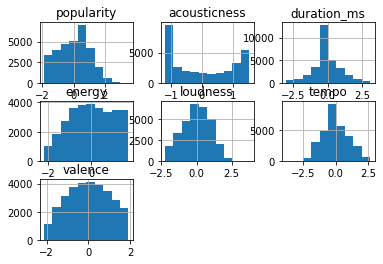

In [52]:
# perform a box-cox transform of the dataset:
power = PowerTransformer(method='box-cox')

# create column transformer:
boxcox_ct = make_column_transformer(
    (power, features),
    remainder='passthrough'
)

# transform the data:
test_set = pd.DataFrame(boxcox_ct.fit_transform(test_set))

# restore labels:
test_set.columns = edit_feature_names(boxcox_ct.get_feature_names_out())

# restore feature types:
restore_types(test_set, numerical_features)

# display histograms:
test_set[features].hist()

### Step 8: Save processed data

In [53]:
test_set.shape

(30931, 116)

In [54]:
#test_set.to_csv('processed_test_set_MARK_II.csv', index=False)
test_set.to_csv('processed_test_set_MARK_I.csv', index=False)

**load the trained model from disk:**

In [1]:
# load the model from disk
#decision_tree_classifier=load(open(filename, 'rb'))
#predictions = decision_tree_classifier.predict(X_test, Y_test)
#print(result)